In [3]:
import pandas as pd

df = pd.read_csv('data1.csv')
df.head()

,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,0,id1240020,1,2016-02-23 07:00:39,2016-02-23 07:12:06,1,-73.985283,40.723553,-73.975433,40.755489,N,687
1,1,id1510937,1,2016-05-05 15:51:18,2016-05-05 16:29:14,1,-73.986282,40.742828,-73.871162,40.774216,N,2276
2,2,id3909687,2,2016-01-31 19:31:24,2016-01-31 19:54:28,2,-73.950233,40.779861,-73.996193,40.726009,N,1384
3,3,id3757092,1,2016-04-23 09:22:37,2016-04-23 09:25:11,1,-73.982208,40.740139,-73.977905,40.746174,N,154
4,4,id3662683,1,2016-03-01 20:36:25,2016-03-01 20:55:39,2,-73.983170,40.777641,-73.938675,40.819790,N,1154


In [ ]:
import numpy as np

df_clean = df.copy()

df_clean['pickup_datetime'] = pd.to_datetime(df_clean['pickup_datetime'])
df_clean['dropoff_datetime'] = pd.to_datetime(df_clean['dropoff_datetime'])

df_clean['pickup_hour'] = df_clean['pickup_datetime'].dt.hour
df_clean['pickup_day'] = df_clean['pickup_datetime'].dt.day
df_clean['pickup_month'] = df_clean['pickup_datetime'].dt.month
df_clean['pickup_weekday'] = df_clean['pickup_datetime'].dt.weekday
df_clean['pickup_weekend'] = (df_clean['pickup_weekday'] >= 5).astype(int)

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371 
    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    a = np.sin(dLat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dLon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

df_clean['distance'] = haversine_distance(
    df_clean['pickup_latitude'], 
    df_clean['pickup_longitude'],
    df_clean['dropoff_latitude'], 
    df_clean['dropoff_longitude']
)

df_clean = pd.get_dummies(df_clean, columns=['store_and_fwd_flag', 'vendor_id'])

columns_to_drop = ['Unnamed: 0', 'id', 'pickup_datetime', 'dropoff_datetime']
df_clean = df_clean.drop(columns=columns_to_drop)

q1 = df_clean['trip_duration'].quantile(0.25)
q3 = df_clean['trip_duration'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_clean = df_clean[(df_clean['trip_duration'] >= lower_bound) & 
                    (df_clean['trip_duration'] <= upper_bound)]

df_clean.head()

Cleaned dataframe shape: (830569, 16)


,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_hour,pickup_day,pickup_month,pickup_weekday,pickup_weekend,distance,store_and_fwd_flag_N,store_and_fwd_flag_Y,vendor_id_1,vendor_id_2
0,1,-73.985283,40.723553,-73.975433,40.755489,687,7,23,2,1,0,3.646860,True,False,True,False
2,2,-73.950233,40.779861,-73.996193,40.726009,1384,19,31,1,6,1,7.130520,True,False,False,True
3,1,-73.982208,40.740139,-73.977905,40.746174,154,9,23,4,5,1,0.762702,True,False,True,False
4,2,-73.983170,40.777641,-73.938675,40.819790,1154,20,1,3,1,0,5.999416,True,False,True,False
5,1,-74.004112,40.742062,-73.861984,40.768486,2029,13,2,3,2,0,12.326845,True,False,True,False


Improved model - RMSE: 201.24, R² Score: 0.7988


Text(0.5, 1.0, 'Predicted vs Actual Trip Duration')

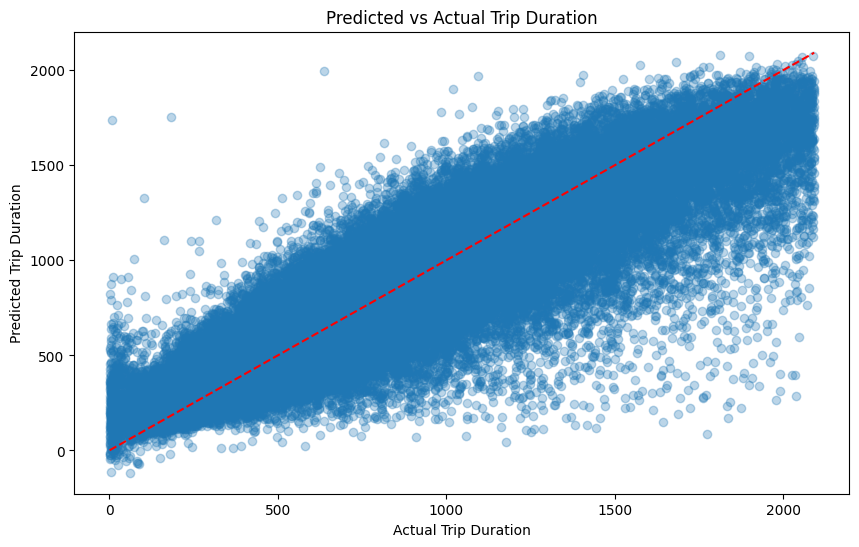

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

X = df_clean.drop(['trip_duration'], axis=1)
y = df_clean['trip_duration']

sample_size = 500000
X_sample = X.sample(n=sample_size, random_state=42)
y_sample = y.loc[X_sample.index]

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

def get_period_of_day(hour):
    if 5 <= hour < 10:
        return 0  
    elif 10 <= hour < 16:
        return 1  
    elif 16 <= hour < 20:
        return 2  
    else:
        return 3 

# busy hours
def is_rush_hour(hour, weekday):

    if weekday < 5: 
        if 7 <= hour < 10 or 16 <= hour < 19:
            return 1
    return 0

# Calculate Manhattan distance
def manhattan_distance(lat1, lon1, lat2, lon2):
    lat_km = abs(lat2 - lat1) * 111
    lon_km = abs(lon2 - lon1) * 111 * np.cos(np.radians((lat1 + lat2) / 2))
    return lat_km + lon_km

for df in [X_train, X_test]:
    df['period_of_day'] = df['pickup_hour'].apply(get_period_of_day)
    df['rush_hour'] = df.apply(lambda x: is_rush_hour(x['pickup_hour'], x['pickup_weekday']), axis=1)
    
    df['manhattan_distance'] = manhattan_distance(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )
    
    df['passenger_distance'] = df['passenger_count'] * df['distance']
    df['weekend_night'] = ((df['pickup_weekend'] == 1) & 
                          ((df['pickup_hour'] < 6) | (df['pickup_hour'] >= 20))).astype(int)
    
    df['delta_lon'] = df['dropoff_longitude'] - df['pickup_longitude']
    df['delta_lat'] = df['dropoff_latitude'] - df['pickup_latitude']

model_improved = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.06,
    max_depth=12,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_improved.fit(X_train, y_train)

y_pred_improved = model_improved.predict(X_test)
rmse_improved = np.sqrt(mean_squared_error(y_test, y_pred_improved))
r2_improved = r2_score(y_test, y_pred_improved)

print(f"RMSE: {rmse_improved:.2f}, R² Score: {r2_improved:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_improved, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Trip Duration')
plt.ylabel('Predicted Trip Duration')
plt.title(f'Predicted vs Actual Trip Duration')